# Quantum Control as Polynomial Optimization: Synthesizing unitary target

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

60

In [2]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials, MomentTools
using TSSOS
using QuadGK
using MosekTools
using JuMP
using Random
using NLopt

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V ./= norm(V, Inf);

In [4]:
H0

3×3 Matrix{Float64}:
 0.0  0.0       0.0
 0.0  0.515916  0.0
 0.0  0.0       1.0

In [5]:
V

3×3 Matrix{Float64}:
 0.0       0.707107  0.0
 0.707107  0.0       1.0
 0.0       1.0       0.0

## Utilities for working with Polynomials

In [6]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [7]:
@polyvar x[1:3]
@polyvar t[1:3]

# final time
const T = 0.5

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T);

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
);

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Chebyshve polynomial approximation for $\exp(\Omega/2)$

In [8]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω/2)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 0.5) * Tₙ₋₁ + 2 * besselj(1, 0.5) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 0.5) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

Ω = convert(typeof(A₁), Ω)

exp½Ω = exp_chebyshev(Ω, 5);

## Construct the polynomial $\tanh_p \frac{\Omega^{(n)}}{2}$ with $n=3$ and $p=5$

## Getting statistic for checking the performance of quantum control formulation as a polynomial optimization

In [9]:
function get_unitray(x::AbstractArray)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

In [10]:
@time begin
    
n_samples = 1000
Random.seed!(6292022)

# randomly generate the coefficients for the polynomial control 
exact_x = -1 .+ 2 * rand(length(x) * n_samples)
exact_x = reshape(exact_x, (length(x), n_samples))

# The values of objective functions for exact x
obj_exact_x = zeros(n_samples)

# the estimate of the global minimum of the polynomial objective function using MomentTools
glob_obj_min = zeros(n_samples)

# the polynomial objective at min_x
glob_obj_min_x = zeros(n_samples)

# The global minimum via TSSOS library
tssos_glob_obj_min = zeros(n_samples)

# Frobenius norm difference between target and obtained unitaries
norm_U_target_minus_obtained = zeros(n_samples)

# Frobenius norm difference between target and the truncated Magnus expansion
norm_U_target_minus_expΩ_exact_x = zeros(n_samples)
norm_U_target_minus_expΩ_min_x = zeros(n_samples)

# Convergence test for the Magnus expansion for the exact control (convergence_test_exact_x < 1)
convergence_test_exact_x = zeros(n_samples)

# Convergence test for the Magnus expansion for the obtained control (convergence_test_min_x < 1)
convergence_test_min_x = zeros(n_samples)

norm_diff_x = zeros(n_samples)

Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = get_unitray(exact_x[:, i])
    
    # get the polynomial objective function
    obj = square_frobenius_norm(
        #I - U_target + (I + U_target) * tanh₅
        exp½Ω' *  U_target - exp½Ω
    )
    
    # save the value of objective function for exact x
    obj_exact_x[i] = obj(exact_x[:, i])
  
    # Perform polynomial optimization using MomentTools
    optimizer = optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)
    glob_obj_min[i], M = minimize(obj, [], [], variables(obj), maxdegree(obj) ÷ 2, optimizer)
    
    # Extract the estimate for the global minimum 
    r = get_minimizers(M)
    obj_min_vals = [obj(r[:, j]) for j=1:size(r)[2]]
    min_x = r[:, argmin(obj_min_vals)]

    # refine the estimate by local minimization
    min_x = local_minimize(obj, min_x)
    
    # the polynomial objective at min_x
    glob_obj_min_x[i] = obj(min_x)
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true)
    
    previous_opt = opt
    
    while ~isnothing(opt)
        previous_opt = opt

        opt,sol,data = tssos_higher!(data; QUIET = true)
    end
    
    tssos_glob_obj_min[i] = previous_opt
        
    # get the Frobenius norm difference between target and obtained unitaries
    norm_U_target_minus_obtained[i] = norm(U_target - get_unitray(min_x))
    
    # check the accuracy of the Magnus expansion
    Ω_exact_x = convert(Matrix{ComplexF64}, subs(Ω, x=>exact_x[:, i]))
    norm_U_target_minus_expΩ_exact_x[i] = norm(U_target - exp(Ω_exact_x))

    Ω_min_x = convert(Matrix{ComplexF64}, subs(Ω, x=>min_x))
    norm_U_target_minus_expΩ_min_x[i] = norm(U_target - exp(Ω_min_x))
    
    # Convergence test for the Magnus expansion for the exact control
    convergence_test_exact_x[i] = quadgk(t -> opnorm(A(t, exact_x[:, i])), 0, T)[1] / π

    # Convergence test for the Magnus expansion for the obtained control
    convergence_test_min_x[i] = quadgk(t -> opnorm(A(t, min_x)), 0, T)[1] / π    
    
    norm_diff_x[i] = norm(exact_x[:, i] - min_x)
end
    
end

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

************************TSSOS************************
TSSOS is launching...
optimum = 2.8567397384915e-8
No higher TSSOS hierarchy!
optimum = 9.330099498645585e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.1756179053592488e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 5.363846700306874e-9
optimum = 5.8608710808006845e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.0118521249555002e-8
No higher TSSOS hierarchy!
************************TSSOS**************

************************TSSOS************************
TSSOS is launching...
optimum = 5.1893017526064895e-9
optimum = 5.260657310685522e-9
optimum = 8.747225047796355e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.1698037256195844e-8
No higher TSSOS hierarchy!
optimum = 7.902660344872496e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 2.3641615999853616e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 5.5467667280821135e-9
No higher TSSOS hierarchy!
optimum = 8.62348795522118e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
*

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 9.518741856119033e-9
No higher TSSOS hierarchy!
optimum = 1.4621271604677008e-8
optimum = 1.4370066933321565e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 4.6466753130507735e-9
optimum = 8.737976498827337e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 6.11283679775

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.879972307463464e-8
optimum = 1.1664472418777616e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 6.451685750711672e-9
optimum = 5.2197334053334314e-9
optimum = 2.0090463404396414e-8
optimum = 6.876174367995516e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.3203969733423373e-8
optimum = 3.639491394791551e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!


************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 2.8565818859364454e-8
optimum = 1.0039597313100329e-6
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 7.115678751183038e-8
optimum = 9.34984466899209e-9
optimum = 1.15580313380991e-8
optimum = 7.519550163902569e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 7.2235677747521385e-9
optimum = 7.627958498062836e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
***

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.2568195445328015e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS

************************TSSOS************************
TSSOS is launching...
optimum = 1.001660148210904e-8
optimum = 7.543106004534319e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 2.9596771556762658e-8
optimum = 5.117803286736173e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.8470840719372882e-8
optimum = 5.8727486055512e-9
optimum = 1.0607459107257821e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.1100591433681107e-8
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 5.612631113452317e-8
No higher TSSOS hierarchy!
************************TSSOS*************

optimum = 8.896813604709922e-9
optimum = 3.3733707801190847e-9
optimum = 2.202140991405383e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 9.19426610054754e-9
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 3.395552841028206e-9
No higher TSSOS hierarchy!

************************TSSOS************************
TSSOS is launching...
optimum = 2.2339743041329617e-8
optimum = 6.847524753400507e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.1191545427128357e-8
optimum = 1.20091222340224e-8
optimum = 1.6130548950909957e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 5.304939137780402e-9
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS*************

TSSOS is launching...
optimum = 4.962589782283496e-9
optimum = 6.032098166092293e-8
optimum = 7.633143948370782e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 6.708402837394347e-9
optimum = 7.770870231007825e-9
optimum = 7.79925469053351e-9
optimum = 1.0338156064429215e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.5454552416677e-8
optimum = 9.616858510977882e-9
optimum = -2.001449879292254e-9
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
*******************

## Saving results

## Analysis

In [11]:
using Plots
using LaTeXStrings

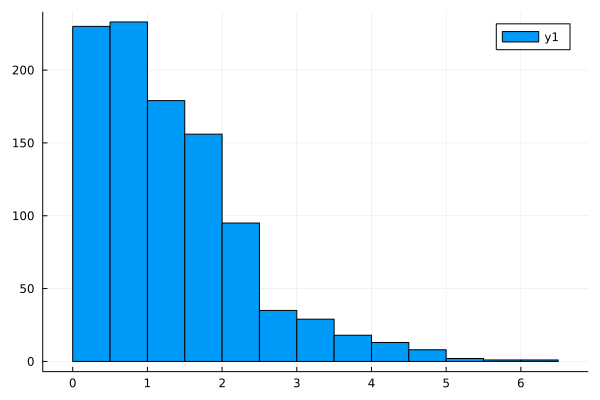

In [12]:
histogram(norm_diff_x)

### Benchmarking TSSOS vs MomentTools libraires

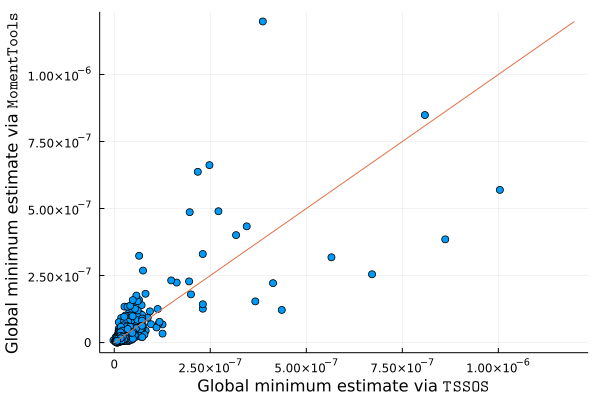

In [48]:
scatter(tssos_glob_obj_min, glob_obj_min, label=nothing)
lower = min(minimum(tssos_glob_obj_min), minimum(glob_obj_min))
higher = max(maximum(tssos_glob_obj_min), maximum(glob_obj_min))
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("Global minimum estimate via " * L"\texttt{TSSOS}")
ylabel!("Global minimum estimate via " * L"\texttt{MomentTools}")
#savefig("Fig_TSSOSvsMomentTools.pdf")

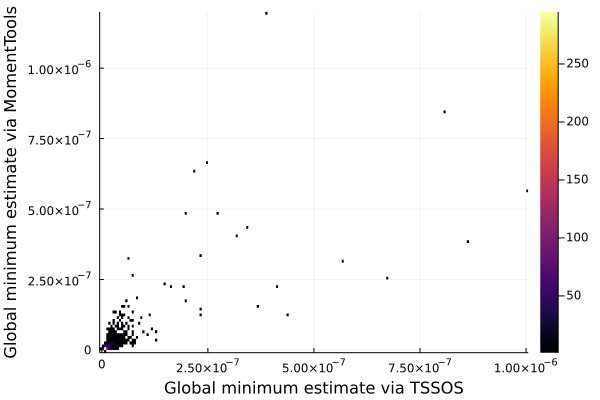

In [49]:
histogram2d(tssos_glob_obj_min, glob_obj_min, label=nothing)
xlabel!("Global minimum estimate via TSSOS")
ylabel!("Global minimum estimate via MomentTools")

### Actual global minimum vs global minimum estimate via MomentTools

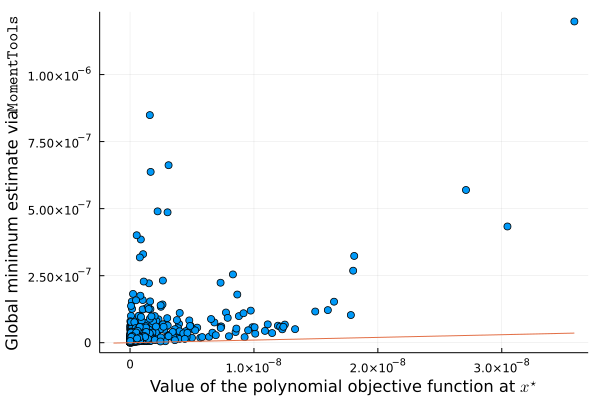

In [51]:
scatter(obj_exact_x, glob_obj_min, label=nothing)
lower = min(minimum(obj_exact_x), minimum(glob_obj_min))
higher = maximum(obj_exact_x)
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("Value of the polynomial objective function at " * L"x^{\star}")
ylabel!("Global minimum estimate via" * L"\texttt{MomentTools}")
#savefig("Fig_MomentToolsvsXstar.pdf")

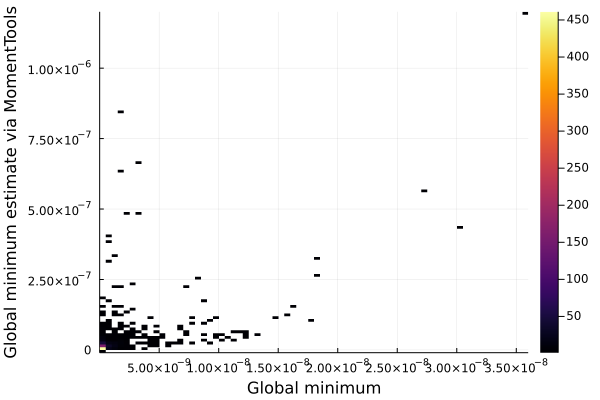

In [52]:
histogram2d(obj_exact_x, glob_obj_min)
xlabel!("Global minimum")
ylabel!("Global minimum estimate via MomentTools")

### Obtained unitray $\hat{U}$ vs the target $U^{\star}$

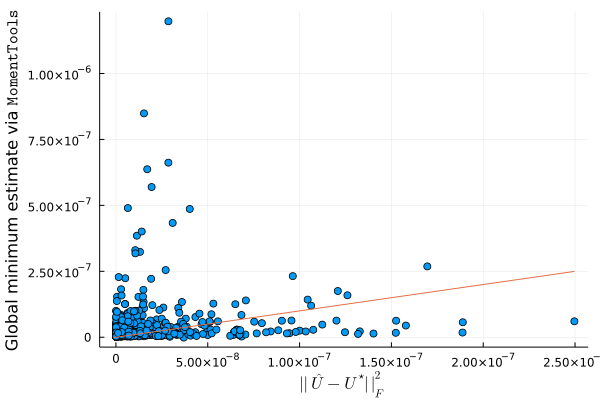

In [54]:
scatter(norm_U_target_minus_obtained .^ 2, glob_obj_min, label=nothing)
lower = min(minimum(norm_U_target_minus_obtained .^ 2), minimum(glob_obj_min))
higher = maximum(norm_U_target_minus_obtained .^ 2)
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!(L"\|\| \widehat{U} - U^{\star} \|\|_F^2" )
ylabel!("Global minimum estimate via " * L"\texttt{MomentTools}")
#savefig("Fig_PolynomialOptVsCoherenControl.pdf")

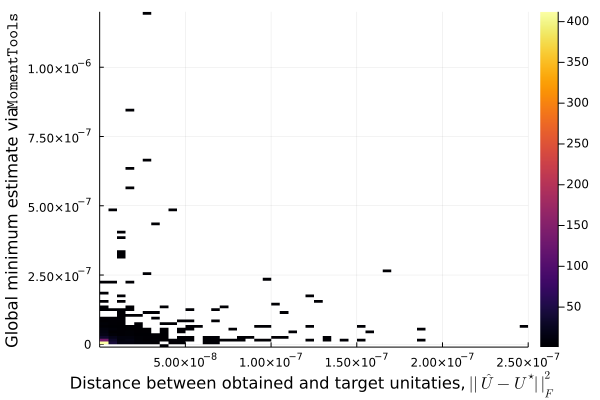

In [18]:
histogram2d(norm_U_target_minus_obtained .^ 2, glob_obj_min)
xlabel!("Distance between obtained and target unitaties, " * L"\|\| \widehat{U} - U^{\star} \|\|_F^2")
ylabel!("Global minimum estimate via" * L"\texttt{MomentTools}")

### Testing approximated exp vs exact exp

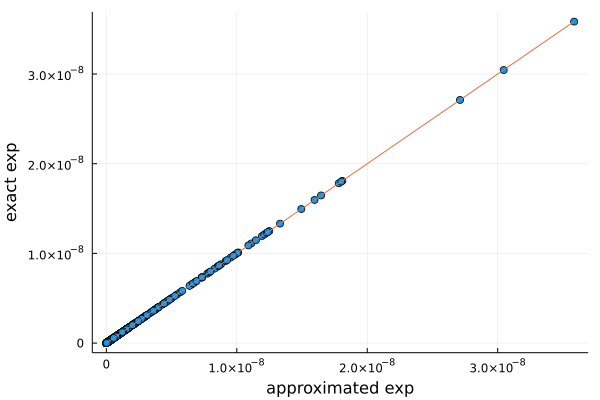

In [23]:
scatter(obj_exact_x, norm_U_target_minus_expΩ_exact_x .^ 2, label=nothing)
lower = min(minimum(norm_U_target_minus_expΩ_exact_x .^ 2), minimum(obj_exact_x))
higher = max(maximum(norm_U_target_minus_expΩ_exact_x .^ 2), maximum(obj_exact_x))
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("approximated exp")
ylabel!("exact exp")

### Convergence tests

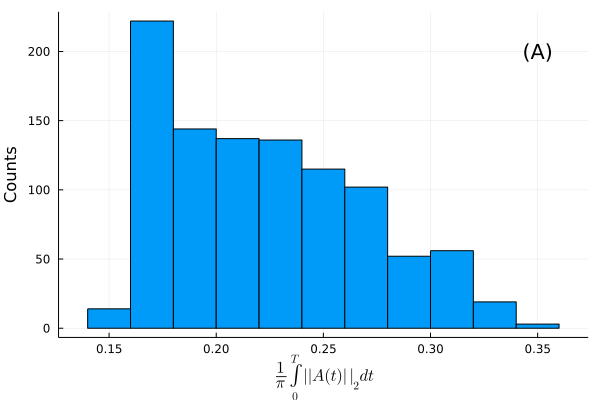

In [56]:
histogram(convergence_test_exact_x, label=nothing)
ylabel!("Counts")
xlabel!(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt", guidefontsize=11,)
annotate!([(0.35, 200, text("(A)"))])
#savefig("Fig_ConvergenceTestXstar.pdf")

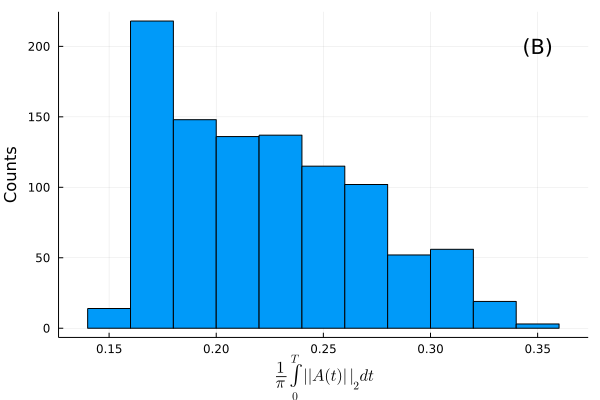

In [58]:
histogram(convergence_test_min_x, label=nothing)
xlabel!(L"\frac{1}{\pi} \int_0^T || A(t) ||_2 dt", guidefontsize=11,)
ylabel!("Counts")
annotate!([(0.35, 200, text("(B)"))])
#savefig("Fig_ConvergenceTestXHat.pdf")